# aSPEM Experiment : analysis




In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from scipy import stats

In [2]:
%matplotlib inline

In [3]:
fig_width = 15

from aSPEM import aSPEM
import bayesianchangepoint as bcp

In [4]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)
    #print(a)

In [5]:
exp = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']:
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [6]:
param = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']:
        a = 'parametre/param_Fit_%s.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)

# Variation de tau

In [7]:
tau_max = 1000
TAU = np.arange(0,tau_max,1)
liste_p_hat_e_tau = pickle.load(open('liste_p_hat_e_tau.pkl', 'rb' ))
liste_p_hat_m_tau = pickle.load(open('liste_p_hat_m_tau.pkl', 'rb' ))

In [8]:
from scipy import stats
def regress(p, b) :
    p=np.asarray(p)
    b=np.asarray(b)
    slope, intercept, r_, p_value, std_err = stats.linregress(p[~np.isnan(b)], b[~np.isnan(b)])
    return r_

In [9]:
liste_tau_e, liste_r_e = {}, {}
liste_tau_m, liste_r_m = {}, {}

for x in range(len(exp)) :
    s = exp[x]['observer'] # sujet
    
    liste_tau_e[s], liste_r_e[s] = {}, {}
    liste_tau_m[s], liste_r_m[s] = {}, {}
    
    N_blocks = exp[x]['N_blocks']
    N_trials = exp[x]['N_trials']
    results = (exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]
    v_anti = param[x]['v_anti']
    
    for block in range(N_blocks) :
        liste_tau_e[s][block], liste_r_e[s][block] = {}, {}
        liste_tau_m[s][block], liste_r_m[s][block] = {}, {}
        
        #----------------------------------------------------
        # Pour chaque pause !
        #----------------------------------------------------
        liste = [0,50,100,150,200]
        for a in range(len(liste)-1) :
            liste_tau_e[s][block][a], liste_r_e[s][block][a] = {}, {}
            liste_tau_m[s][block][a], liste_r_m[s][block][a] = {}, {}
            
            r_results_e, r_va_e = [], []
            r_results_m, r_va_m = [], []
            for t in range(tau_max) :
                tau = TAU[t]
                
                phat = liste_p_hat_e_tau['%s'%tau][block][liste[a]:liste[a+1]]
                r_results_e.append(regress(phat, results[liste[a]:liste[a+1], block]))
                r_va_e.append(regress(phat, v_anti[block][liste[a]:liste[a+1]]))
            
                phat = liste_p_hat_m_tau['%s'%tau][block][liste[a]:liste[a+1]]
                r_results_m.append(regress(phat, results[liste[a]:liste[a+1], block]))
                r_va_m.append(regress(phat, v_anti[block][liste[a]:liste[a+1]]))
            
            
            liste_tau_e[s][block][a]['result'] = [r_results_e.index(np.nanmax(r_results_e)), np.nanmax(r_results_e)]
            liste_tau_e[s][block][a]['va'] = [r_va_e.index(np.nanmax(r_va_e)), np.nanmax(r_va_e)]
            liste_r_e[s][block][a]['result'] = r_results_e
            liste_r_e[s][block][a]['va'] = r_va_e
            
            liste_tau_m[s][block][a]['result'] = [r_results_m.index(np.nanmax(r_results_m)), np.nanmax(r_results_m)]
            liste_tau_m[s][block][a]['va'] = [r_va_m.index(np.nanmax(r_va_m)), np.nanmax(r_va_m)]
            liste_r_m[s][block][a]['result'] = r_results_m
            liste_r_m[s][block][a]['va'] = r_va_m

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


## Bet et VA

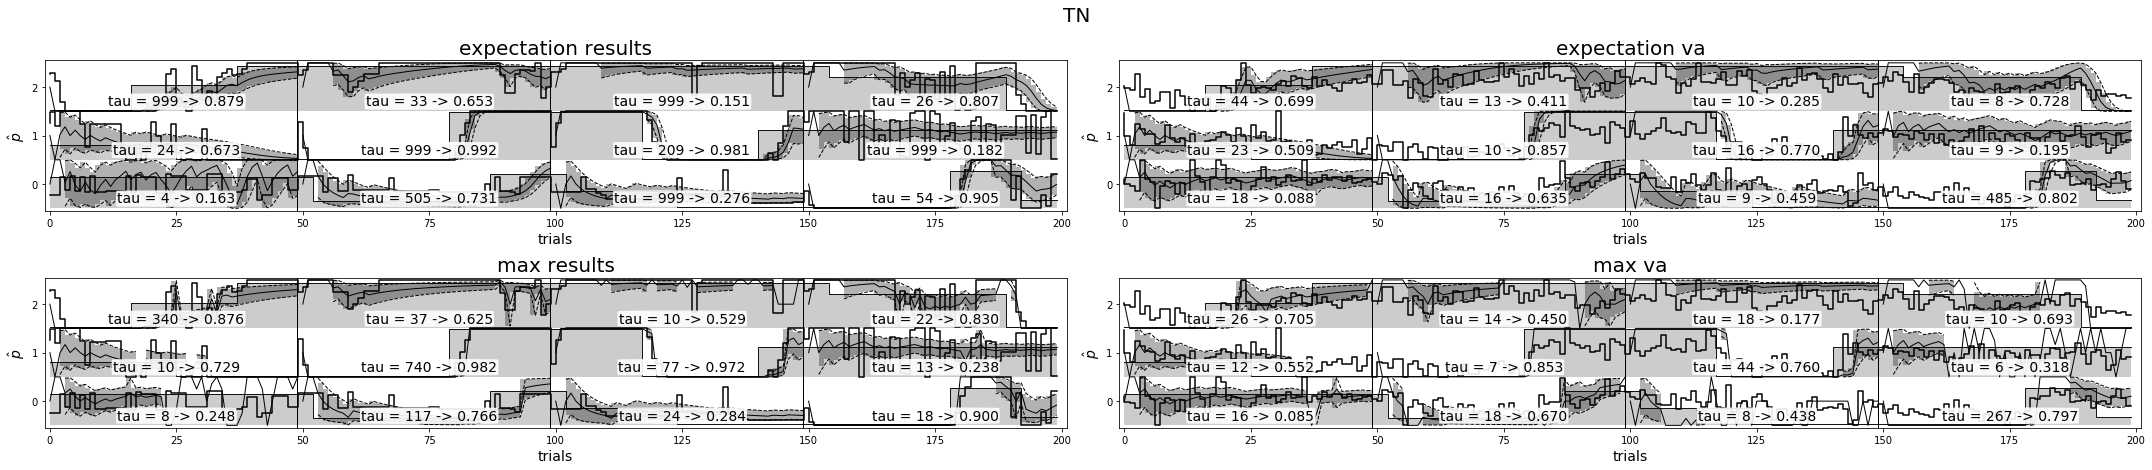

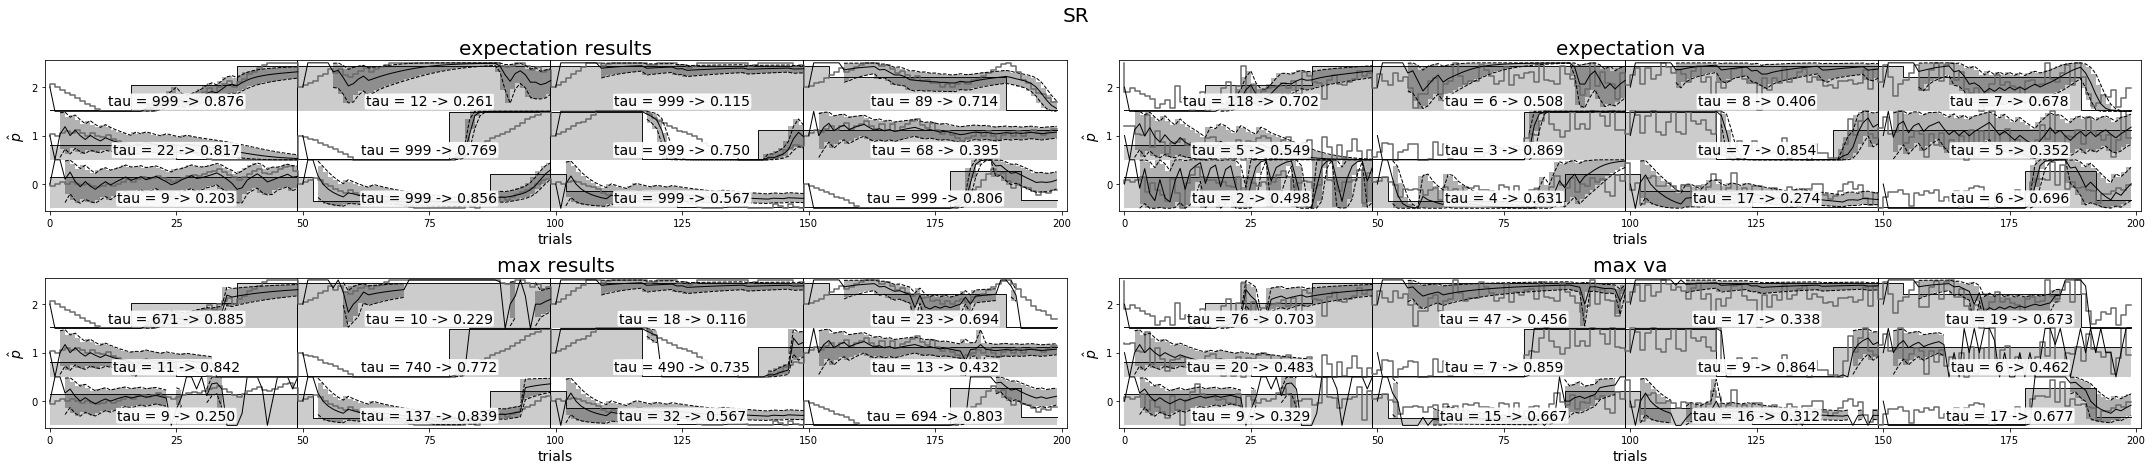

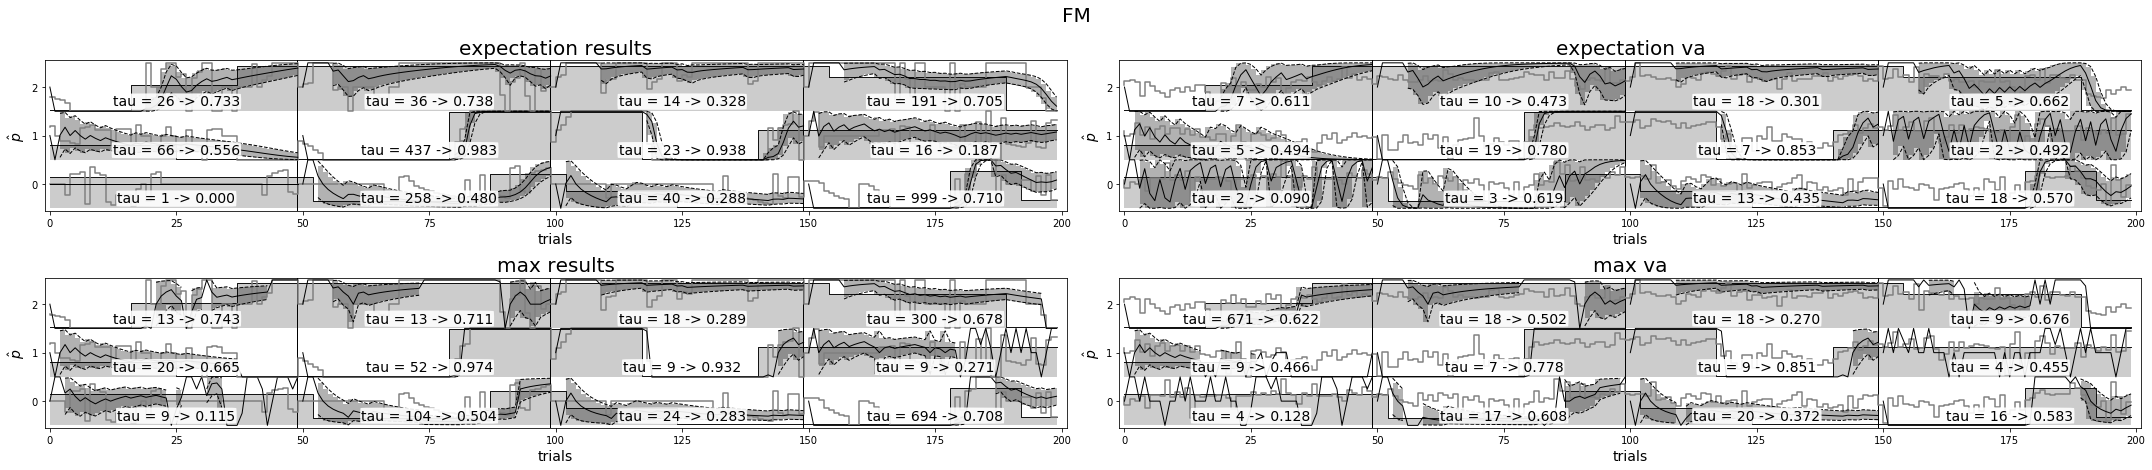

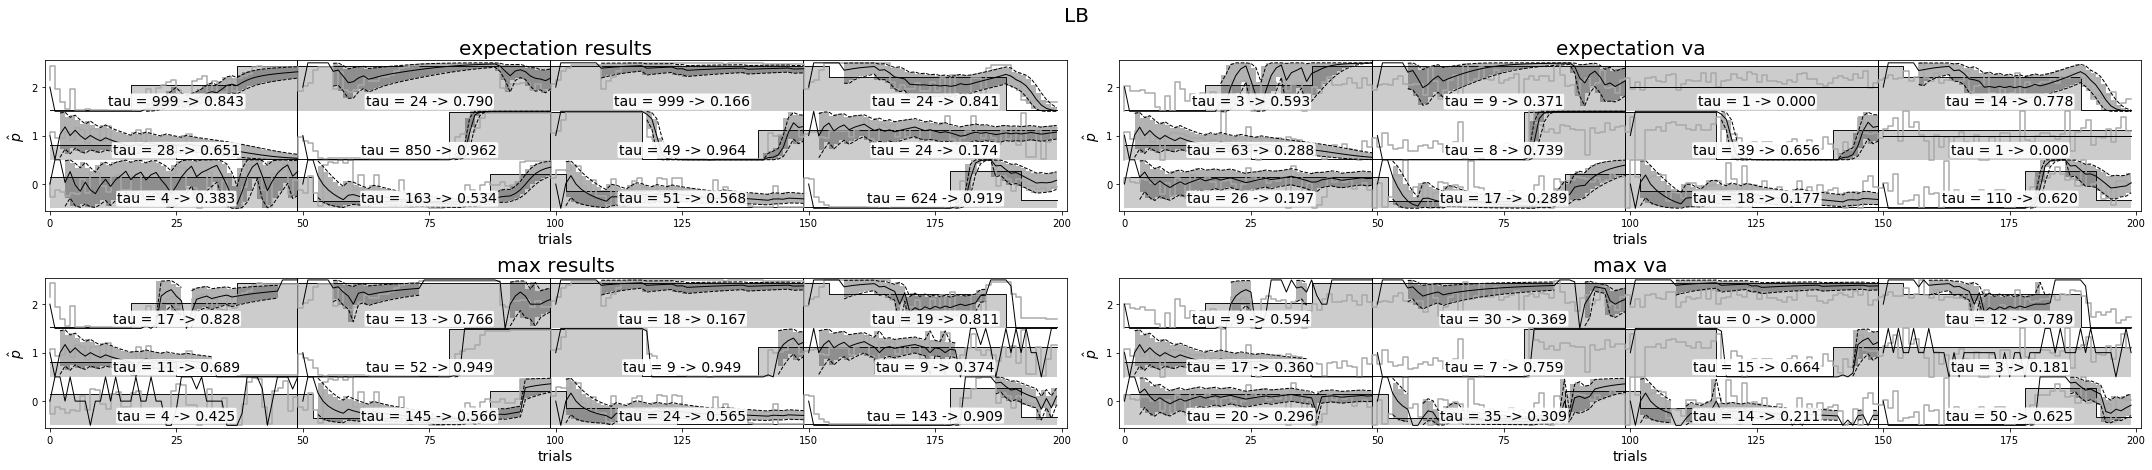

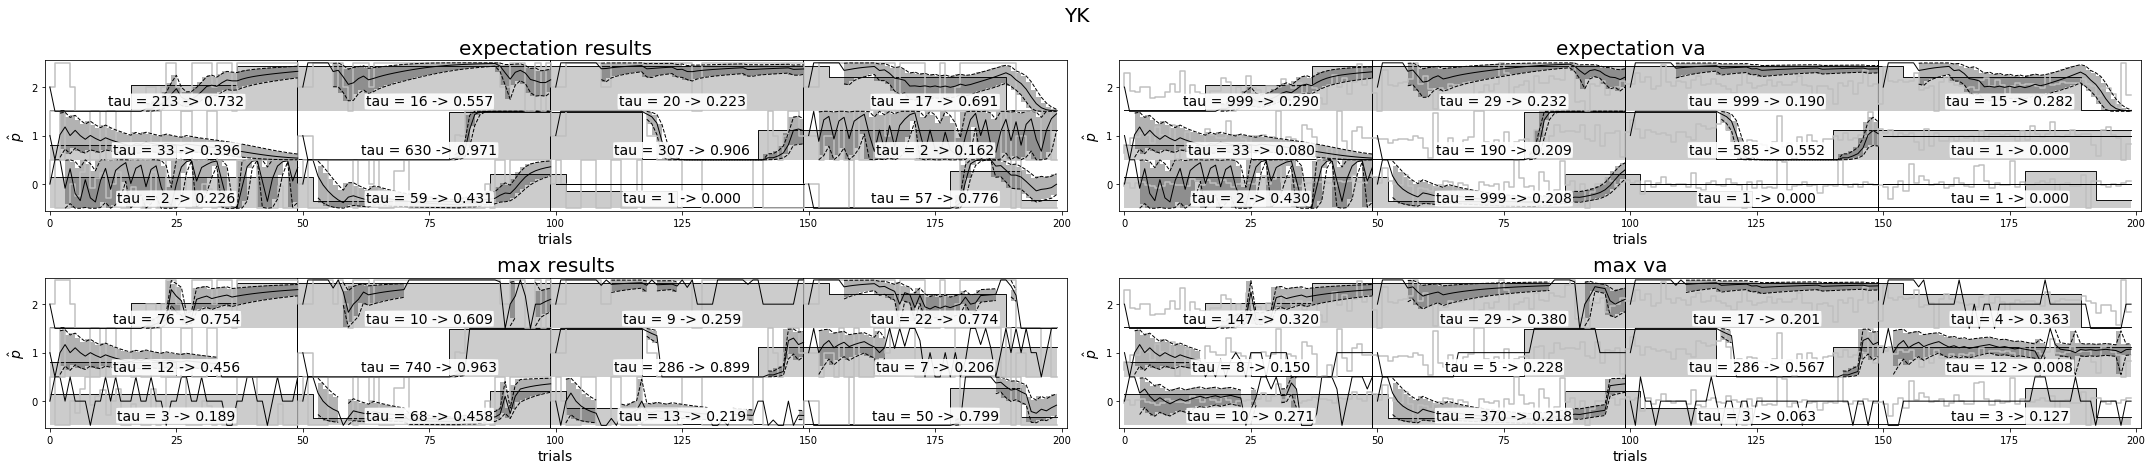

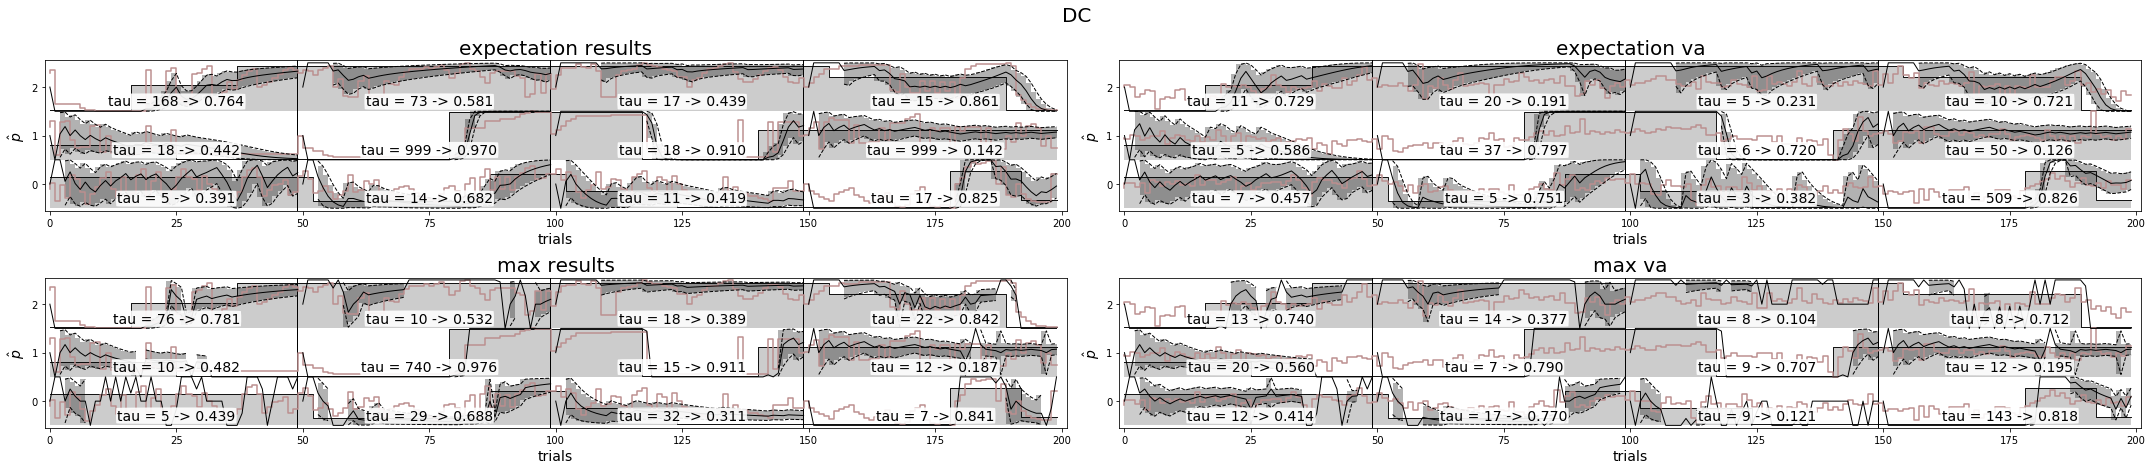

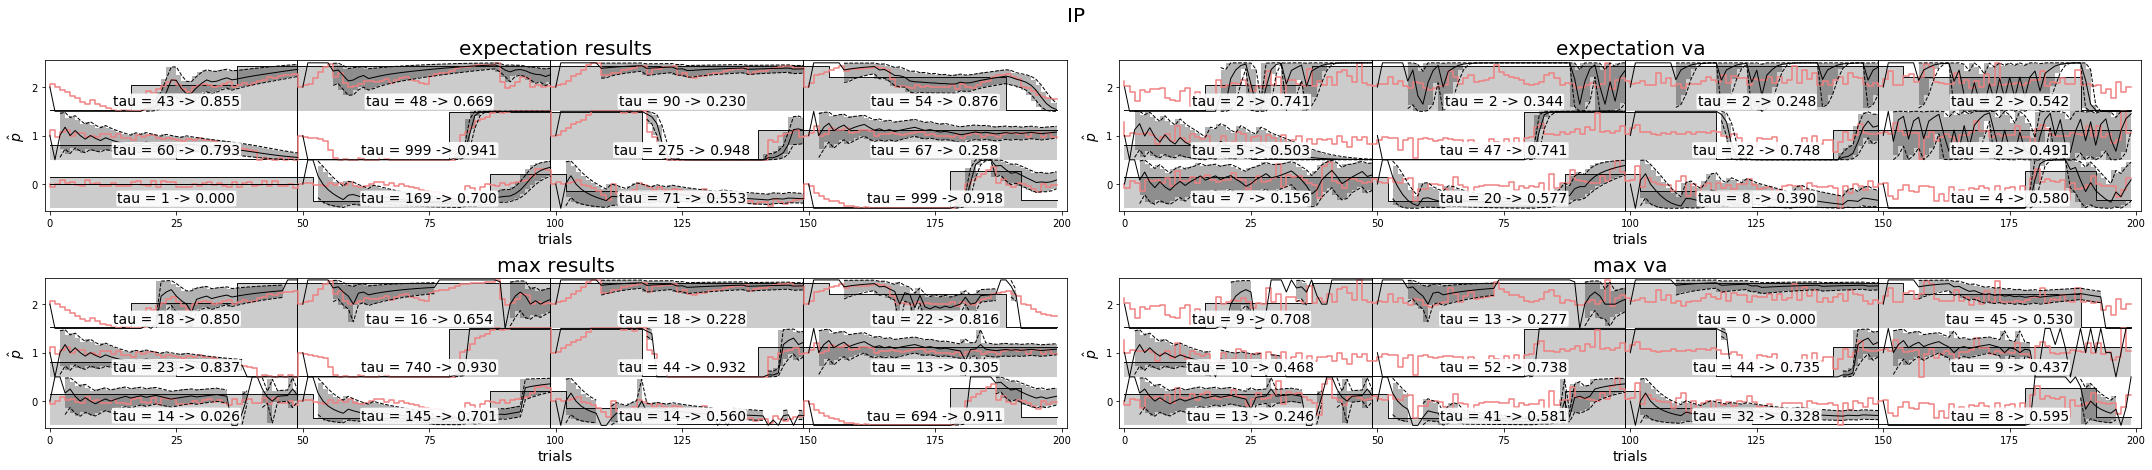

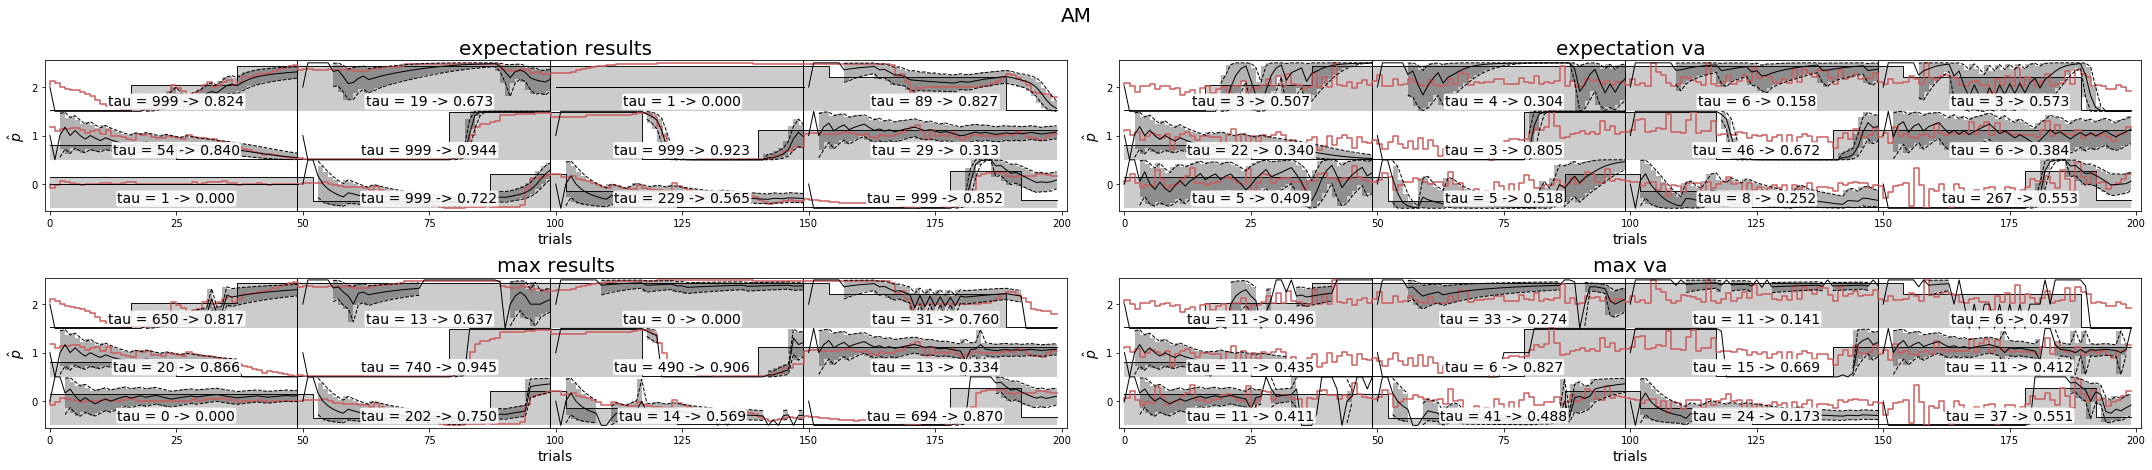

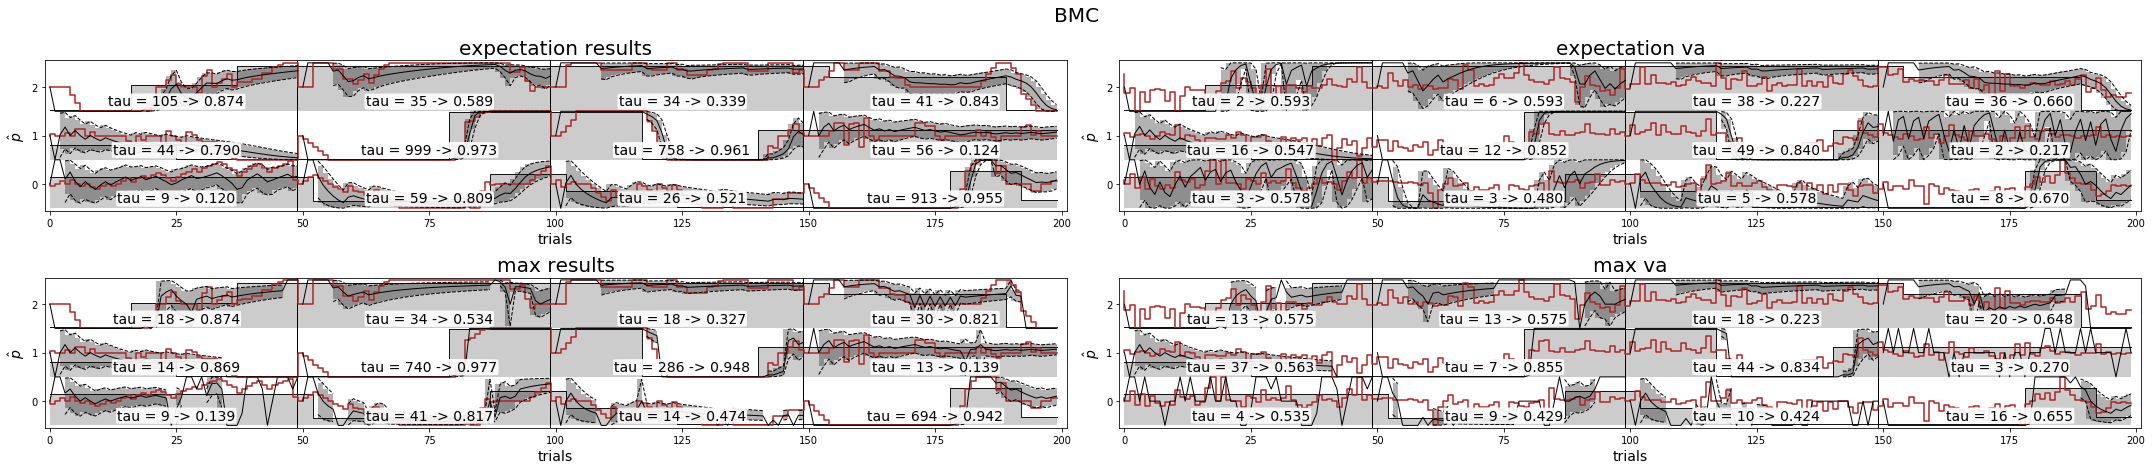

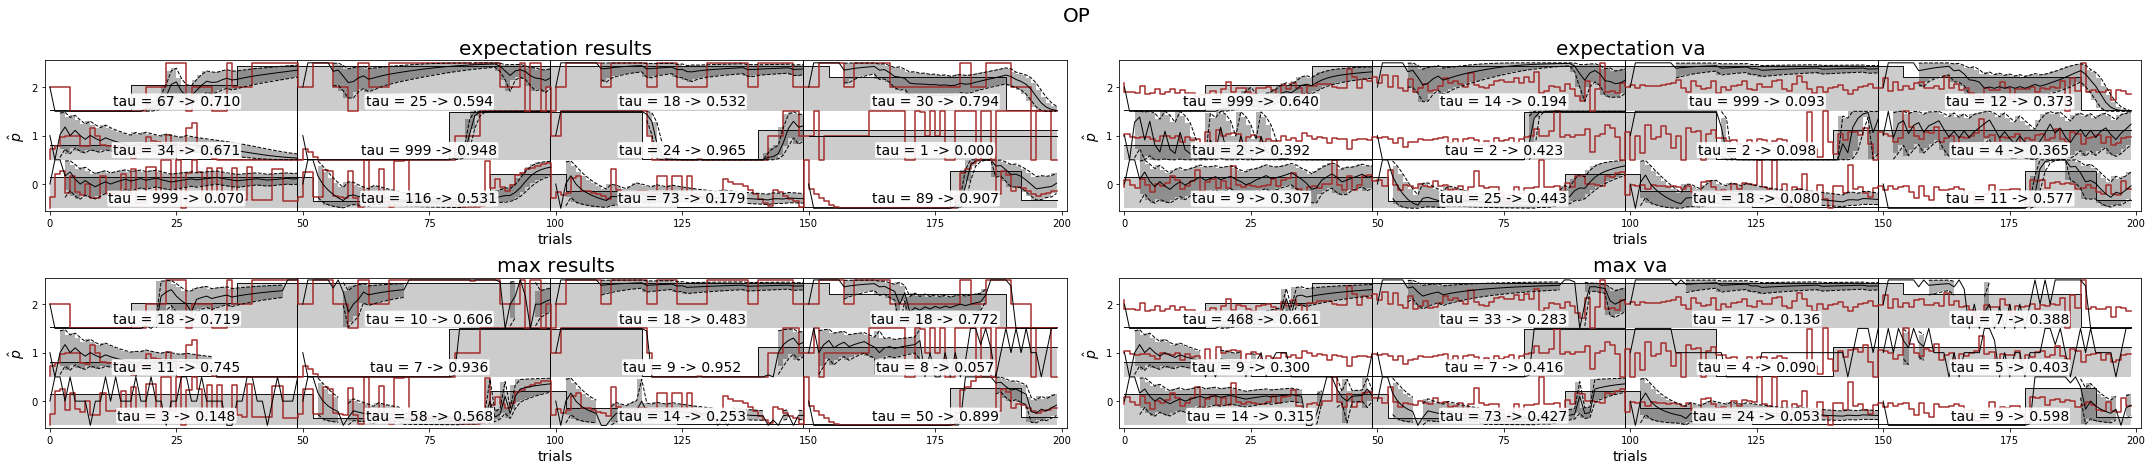

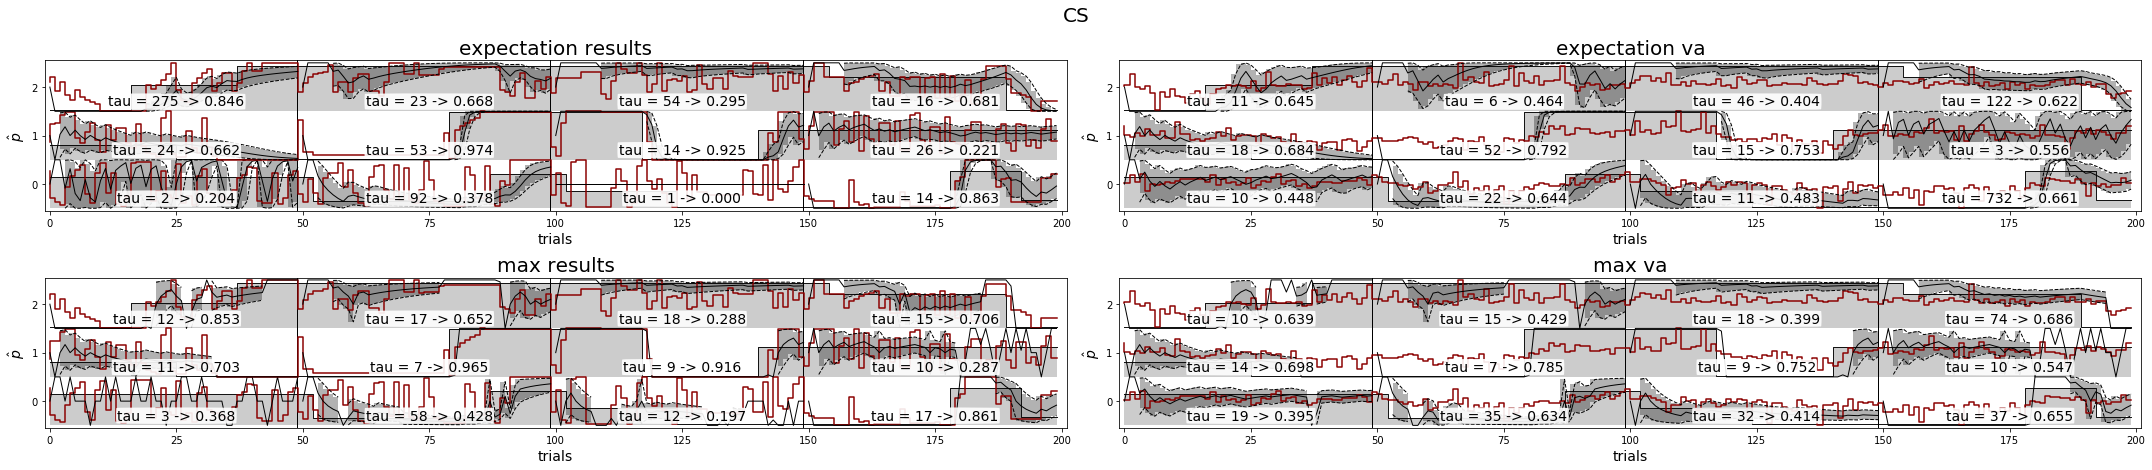

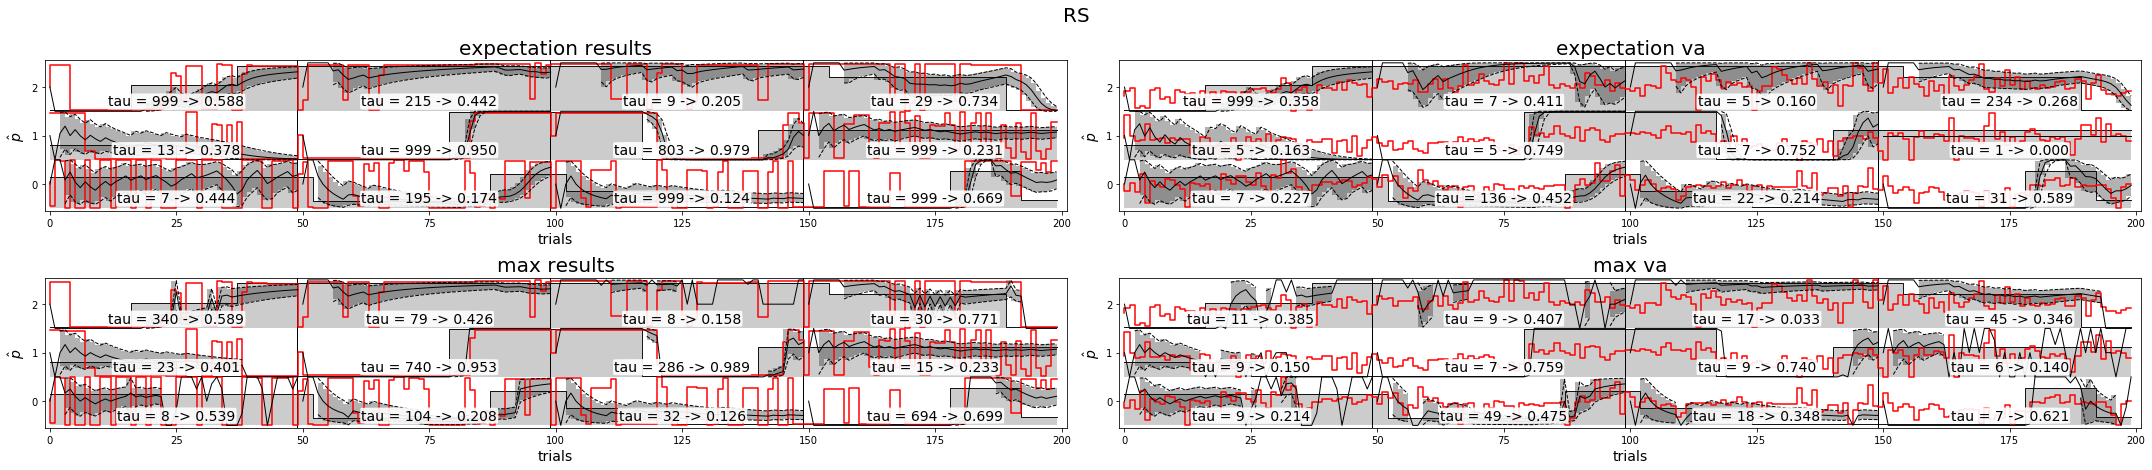

In [10]:
for x, color in enumerate(['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']):
    fig, axs = plt.subplots(2, 2, figsize=(2*fig_width, 2*fig_width/(1.6180*3)))
    
    N_trials = exp[x]['N_trials']
    N_blocks = exp[x]['N_blocks']
    p = exp[x]['p']
    sujet = exp[x]['observer'] # sujet
    results = (exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]
    v_anti = param[x]['v_anti']
    
    stick = np.zeros_like(p)
    stick[:, :, 0] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    stick[:, :, 1] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    stick[:, :, 2] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    
    plt.suptitle('%s'%(exp[x]['observer']), fontsize=20, y=1.05)
    for s, mode in enumerate(['expectation', 'max']):
        
        if mode == 'expectation' :
            liste_tau = liste_tau_e
        elif mode == 'max' :
            liste_tau = liste_tau_m
        
        for a in range(2) :
            axs[s][a].step(range(N_trials), p[:, :, 1]+stick[:, :, 1], lw=1, c='k', alpha=.9)
            axs[s][a].axis('tight')
            axs[s][a].set_yticks(np.arange(N_blocks)+.5)
            axs[s][a].set_yticklabels(np.arange(N_blocks) )
            axs[s][a].set_ylabel(r'$\^p$', fontsize=14)
            axs[s][a].bar(49, 3.1, bottom=-0.05, color='k', width=.2, linewidth=0)
            axs[s][a].bar(99, 3.1, bottom=-0.05, color='k', width=.2, linewidth=0)
            axs[s][a].bar(149, 3.1, bottom=-0.05, color='k', width=.2, linewidth=0)

        for block in range(N_blocks):
            axs[s][0].step(range(N_trials), block + results[:, block],  color=color, lw=1.5)
            axs[s][1].step(range(N_trials), block+((np.array(v_anti[block])-np.nanmin(v_anti))/(np.nanmax(v_anti)-np.nanmin(v_anti))),
                        color=color, lw=1.5)
            
            for a in range(2) :
                axs[s][a].fill_between(range(N_trials), block + np.zeros_like(p[:, block, 1]), block + p[:, block, 1],
                                    lw=.5, alpha=.2, facecolor='black', step='pre')

            #----------------------------------------------------
            # Pour chaque pause !
            #----------------------------------------------------
            liste = [0,50,100,150,200]
            for a in range(len(liste)-1) :
                
                tau = liste_tau[sujet][block][a]['result'][0]
                if tau != 0 :
                    h = 1/tau
                else :
                    h = 0
                p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=h, p0=.5)
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
                p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
                
                for i_trial in range(50):
                    p_low[i_trial], p_sup[i_trial] = stats.beta.ppf([.05, .95], a=p_hat[i_trial]*r_hat[i_trial], b=(1-p_hat[i_trial])*r_hat[i_trial])
                axs[s][0].plot(np.arange(liste[a], liste[a+1]), block + p_hat, c='k',  lw=1)
                axs[s][0].plot(np.arange(liste[a], liste[a+1]), block + p_sup, 'k--', lw=1)
                axs[s][0].plot(np.arange(liste[a], liste[a+1]), block + p_low, 'k--', lw=1)
                axs[s][0].fill_between(np.arange(liste[a], liste[a+1]), block + p_sup, block + p_low, lw=.5, alpha=.3, facecolor='k', step='pre')
                axs[s][0].text(liste[a]+(liste[a+1]-liste[a])/2, block+0.2, 'tau = %s -> %0.3f'%(tau, liste_tau[sujet][block][a]['result'][1]),
                            color='k',bbox={'fc':'white', 'alpha':0.9,'lw':0, 'pad':0.1, 'boxstyle':'round4'},
                            va='center', ha='center', fontsize=14)
                
                tau = liste_tau[sujet][block][a]['va'][0]
                if tau != 0 :
                    h = 1/tau
                else :
                    h = 0
                p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=h, p0=.5)
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
                p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
                
                for i_trial in range(50):
                    p_low[i_trial], p_sup[i_trial] = stats.beta.ppf([.05, .95], a=p_hat[i_trial]*r_hat[i_trial], b=(1-p_hat[i_trial])*r_hat[i_trial])
                axs[s][1].plot(np.arange(liste[a], liste[a+1]), block + p_hat, c='k',  lw=1)
                axs[s][1].plot(np.arange(liste[a], liste[a+1]), block + p_sup, 'k--', lw=1)
                axs[s][1].plot(np.arange(liste[a], liste[a+1]), block + p_low, 'k--', lw=1)
                axs[s][1].fill_between(np.arange(liste[a], liste[a+1]), block + p_sup, block + p_low, lw=.5, alpha=.3, facecolor='k', step='pre')
                axs[s][1].text(liste[a]+(liste[a+1]-liste[a])/2, block+0.2, 'tau = %s -> %0.3f'%(tau, liste_tau[sujet][block][a]['va'][1]),
                            color='k',bbox={'fc':'white', 'alpha':0.9,'lw':0, 'pad':0.1, 'boxstyle':'round4'},
                            va='center', ha='center', fontsize=14)
        axs[s][0].set_title('%s results'%(mode), fontsize=20)    
        axs[s][1].set_title('%s va'%(mode), fontsize=20)   
        for a in range(2) :  
            axs[s][a].set_ylim(-.05, N_blocks + .05)
            axs[s][a].set_xlim(-1, N_trials + 1)
            axs[s][a].set_xlabel('trials', fontsize=14)
            
            fig.tight_layout()
        
    plt.show()

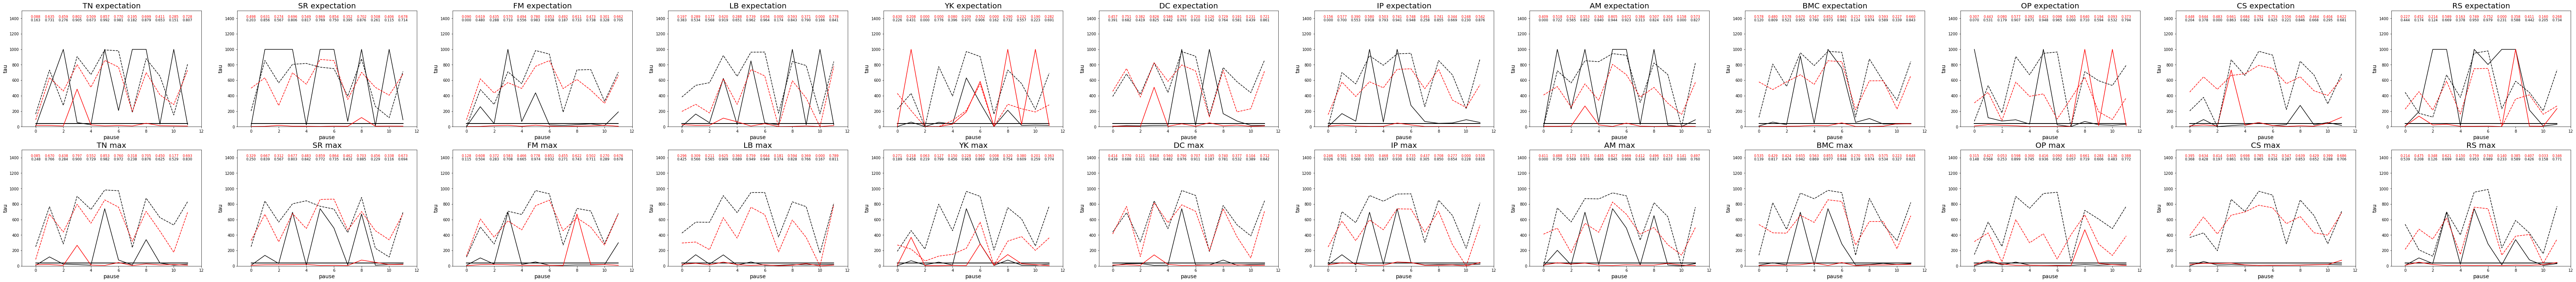

In [11]:
fig, axs = plt.subplots(2, len(exp), figsize=((fig_width*len(exp))/1.5, 2*(fig_width/1.5)/(1.6180)))

for x in range(len(exp)):
    sujet = exp[x]['observer'] # sujet
    N_blocks = exp[x]['N_blocks']
    axs[0][x].set_title('%s expectation'%(exp[x]['observer']), fontsize=20)
    axs[1][x].set_title('%s max'%(exp[x]['observer']), fontsize=20)
    
    for a in range(2) :
        axs[a][x].plot(range(len(exp)), np.ones(len(exp))*40, color='k', linewidth=2)

    tau_r_e, tau_r_m = [],[]
    coco_r_e, coco_r_m = [],[]
    tau_va_e, tau_va_m = [],[]
    coco_va_e, coco_va_m = [],[]
    
    baba = 0
    for block in range(N_blocks) :
        for a in range(len(liste_tau_e[sujet][block])) :
            axs[0][x].text(baba, 1400, '%0.3f'%(liste_tau_e[sujet][block][a]['result'][1]),color='k', ha='center', va='top', fontsize=9)
            axs[0][x].text(baba, 1400, '%0.3f'%(liste_tau_e[sujet][block][a]['va'][1]),color='r', ha='center', va='bottom', fontsize=9)

            axs[1][x].text(baba, 1400, '%0.3f'%(liste_tau_m[sujet][block][a]['result'][1]),color='k', ha='center', va='top', fontsize=9)
            axs[1][x].text(baba, 1400, '%0.3f'%(liste_tau_m[sujet][block][a]['va'][1]),color='r', ha='center', va='bottom', fontsize=9)

                
            tau_r_e.append(liste_tau_e[sujet][block][a]['result'][0])
            tau_r_m.append(liste_tau_m[sujet][block][a]['result'][0])
            coco_r_e.append(liste_tau_e[sujet][block][a]['result'][1]*1000)
            coco_r_m.append(liste_tau_m[sujet][block][a]['result'][1]*1000)
            
            tau_va_e.append(liste_tau_e[sujet][block][a]['va'][0])
            tau_va_m.append(liste_tau_m[sujet][block][a]['va'][0])
            coco_va_e.append(liste_tau_e[sujet][block][a]['va'][1]*1000)
            coco_va_m.append(liste_tau_m[sujet][block][a]['va'][1]*1000)
            
            baba=baba+1

    axs[0][x].plot(tau_r_e, c='k')
    axs[0][x].plot(tau_va_e, c='r')
    axs[0][x].plot(coco_r_e, '--k')
    axs[0][x].plot(coco_va_e, '--r')
    
    axs[1][x].plot(tau_r_m, c='k')
    axs[1][x].plot(tau_va_m, c='r')
    axs[1][x].plot(coco_r_m, '--k')
    axs[1][x].plot(coco_va_m, '--r')

    
    for a in range(2) :
        axs[a][x].set_ylabel('tau', fontsize=14)
        axs[a][x].set_xlabel('pause', fontsize=14)
        axs[a][x].axis([-1, 12, 0, 1500])
plt.show()

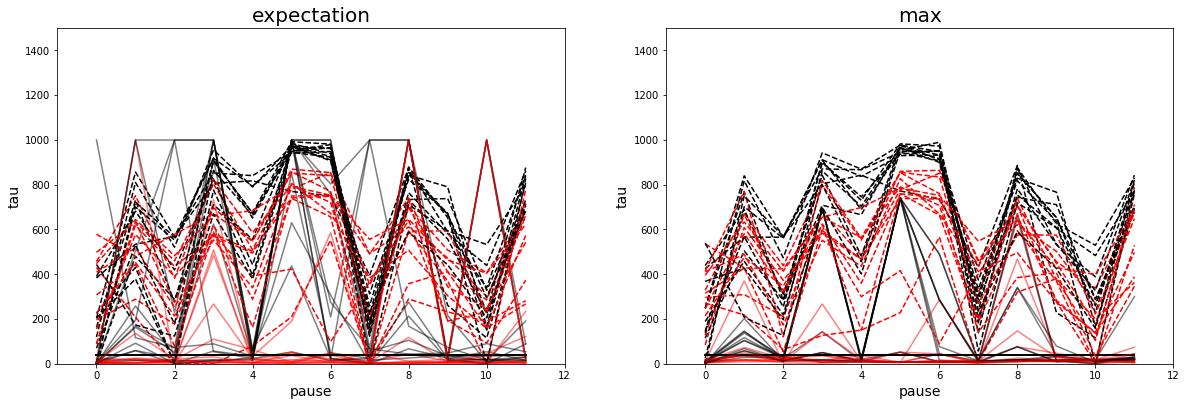

In [12]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width*2)/1.5, (fig_width/1.5)/(1.6180)))
axs[0].set_title('expectation', fontsize=20)
axs[1].set_title('max', fontsize=20)
for x in range(len(exp)):
    sujet = exp[x]['observer'] # sujet
    N_blocks = exp[x]['N_blocks']
    
    for a in range(2) :
        axs[a].plot(range(len(exp)), np.ones(len(exp))*40, color='k', linewidth=2)

    tau_r_e, tau_r_m = [],[]
    coco_r_e, coco_r_m = [],[]
    
    tau_va_e, tau_va_m = [],[]
    coco_va_e, coco_va_m = [],[]
    
    baba = 0
    for block in range(N_blocks) :
        for a in range(len(liste_tau_e[sujet][block])) :

            tau_r_e.append(liste_tau_e[sujet][block][a]['result'][0])
            tau_r_m.append(liste_tau_m[sujet][block][a]['result'][0])
            coco_r_e.append(liste_tau_e[sujet][block][a]['result'][1]*1000)
            coco_r_m.append(liste_tau_m[sujet][block][a]['result'][1]*1000)
            
            tau_va_e.append(liste_tau_e[sujet][block][a]['va'][0])
            tau_va_m.append(liste_tau_m[sujet][block][a]['va'][0])
            coco_va_e.append(liste_tau_e[sujet][block][a]['va'][1]*1000)
            coco_va_m.append(liste_tau_m[sujet][block][a]['va'][1]*1000)
            
            baba=baba+1

    
    axs[0].plot(tau_r_e, c='k', alpha=.5)
    axs[0].plot(tau_va_e, c='r', alpha=.5)
    axs[0].plot(coco_r_e, '--k')
    axs[0].plot(coco_va_e, '--r')
    
    axs[1].plot(tau_r_m, c='k', alpha=.5)
    axs[1].plot(tau_va_m, c='r', alpha=.5)
    axs[1].plot(coco_r_m, '--k')
    axs[1].plot(coco_va_m, '--r')

for a in range(2) :
    axs[a].set_ylabel('tau', fontsize=14)
    axs[a].set_xlabel('pause', fontsize=14)
    axs[a].axis([-1, 12, 0, 1500])

plt.show()

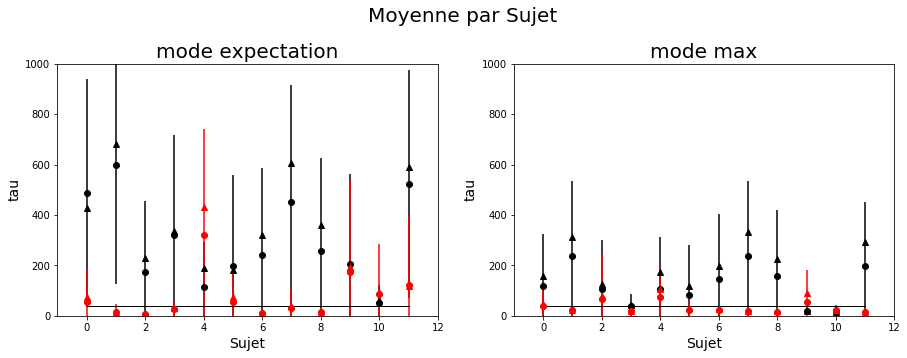

In [13]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), 1*(fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par Sujet', fontsize=20, y=1.05)

for a in range(2) :
    axs[a].plot(range(len(exp)), np.ones(len(exp))*40, color='k', linewidth=1)

for x in range(len(exp)):
    sujet = exp[x]['observer'] # sujet
    N_blocks = exp[x]['N_blocks']
    #axs.plot(range(len(exp)), np.ones(len(exp))*40, color='k', linewidth=2)

    tau_r_e, tau_r_m = [],[]
    coco_r_e, coco_r_m = [],[]

    tau_va_e, tau_va_m = [],[]
    coco_va_e, coco_va_m = [],[]
    
    for block in range(N_blocks) :
        for a in range(len(liste_tau_e[sujet][block])) :

            tau_r_e.append(liste_tau_e[sujet][block][a]['result'][0])
            tau_r_m.append(liste_tau_m[sujet][block][a]['result'][0])
            coco_r_e.append(liste_tau_e[sujet][block][a]['result'][1])
            coco_r_m.append(liste_tau_m[sujet][block][a]['result'][1])
            
            tau_va_e.append(liste_tau_e[sujet][block][a]['va'][0])
            tau_va_m.append(liste_tau_m[sujet][block][a]['va'][0])
            coco_va_e.append(liste_tau_e[sujet][block][a]['va'][1])
            coco_va_m.append(liste_tau_m[sujet][block][a]['va'][1])

    axs[0].errorbar(x, np.mean(tau_r_e), yerr=np.std(tau_r_e),color='k', fmt='o')
    axs[0].errorbar(x, np.average(tau_r_e, weights=coco_r_e),color='k', fmt='^')
    axs[0].errorbar(x, np.mean(tau_va_e), yerr=np.std(tau_va_e),color='r', fmt='o')
    axs[0].errorbar(x, np.average(tau_va_e, weights=coco_va_e),color='r', fmt='^')

    axs[1].errorbar(x, np.mean(tau_r_m), yerr=np.std(tau_r_m),color='k', fmt='o')
    axs[1].errorbar(x, np.average(tau_r_m, weights=coco_r_m),color='k', fmt='^')
    axs[1].errorbar(x, np.mean(tau_va_m), yerr=np.std(tau_va_m),color='r', fmt='o')
    axs[1].errorbar(x, np.average(tau_va_m, weights=coco_va_m),color='r', fmt='^')


axs[0].set_title('mode expectation', fontsize=20)
axs[1].set_title('mode max', fontsize=20)
for a in range(2) :
    axs[a].set_ylabel('tau', fontsize=14)
    axs[a].set_xlabel('Sujet', fontsize=14)
    axs[a].axis([-1, 12, -0.03, 1000])
plt.show()


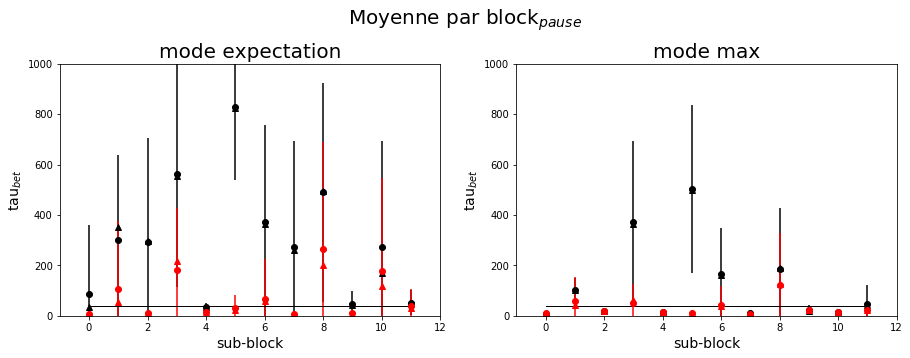

In [14]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), 1*(fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par block$_{pause}$', fontsize=20, y=1.05)

for a in range(2) :
    axs[a].plot(range(len(exp)), np.ones(len(exp))*40, color='k', linewidth=1)

tau_r_e, tau_r_m = [],[]
coco_r_e, coco_r_m = [],[]
tau_va_e, tau_va_m = [],[]
coco_va_e, coco_va_m = [],[]
for block in range(N_blocks) :
    for a in range(len(liste_tau_e[sujet][block])) :
        tau_r_e.append([])
        tau_r_m.append([])
        coco_r_e.append([])
        coco_r_m.append([])
        
        tau_va_e.append([])
        tau_va_m.append([])
        coco_va_e.append([])
        coco_va_m.append([])
        
for x in range(len(exp)):
    sujet = exp[x]['observer'] # sujet
    N_blocks = exp[x]['N_blocks']
    
    baba = 0
    for block in range(N_blocks) :
        for a in range(len(liste_tau_e[sujet][block])) :
            tau_r_e[baba].append(liste_tau_e[sujet][block][a]['result'][0])
            tau_r_m[baba].append(liste_tau_m[sujet][block][a]['result'][0])
            coco_r_e[baba].append(liste_tau_e[sujet][block][a]['result'][1])
            coco_r_m[baba].append(liste_tau_m[sujet][block][a]['result'][1])
            
            tau_va_e[baba].append(liste_tau_e[sujet][block][a]['va'][0])
            tau_va_m[baba].append(liste_tau_m[sujet][block][a]['va'][0])
            coco_va_e[baba].append(liste_tau_e[sujet][block][a]['va'][1])
            coco_va_m[baba].append(liste_tau_m[sujet][block][a]['va'][1])
            
            baba=baba+1

for baba in range(len(tau_r_e)) :
    axs[0].errorbar(baba, np.mean(tau_r_e[baba]), yerr=np.std(tau_r_e[baba]),color='k', fmt='o')
    axs[0].errorbar(baba, np.average(tau_r_e[baba], weights=coco_r_e[baba]),color='k', fmt='^')
    axs[0].errorbar(baba, np.mean(tau_va_e[baba]), yerr=np.std(tau_va_e[baba]),color='r', fmt='o')
    axs[0].errorbar(baba, np.average(tau_va_e[baba], weights=coco_va_e[baba]),color='r', fmt='^')
    
    axs[1].errorbar(baba, np.mean(tau_r_m[baba]), yerr=np.std(tau_r_m[baba]),color='k', fmt='o')
    axs[1].errorbar(baba, np.average(tau_r_m[baba], weights=coco_r_m[baba]),color='k', fmt='^')
    axs[1].errorbar(baba, np.mean(tau_va_m[baba]), yerr=np.std(tau_va_m[baba]),color='r', fmt='o')
    axs[1].errorbar(baba, np.average(tau_va_m[baba], weights=coco_va_m[baba]),color='r', fmt='^')


axs[0].set_title('mode expectation', fontsize=20)
axs[1].set_title('mode max', fontsize=20)

for a in range(2) :
    axs[a].set_ylabel('tau$_{bet}$', fontsize=14)
    axs[a].set_xlabel('sub-block', fontsize=14)
    axs[a].axis([-1, 12, -0.03, 1000])
plt.show()

# figure Final !!!

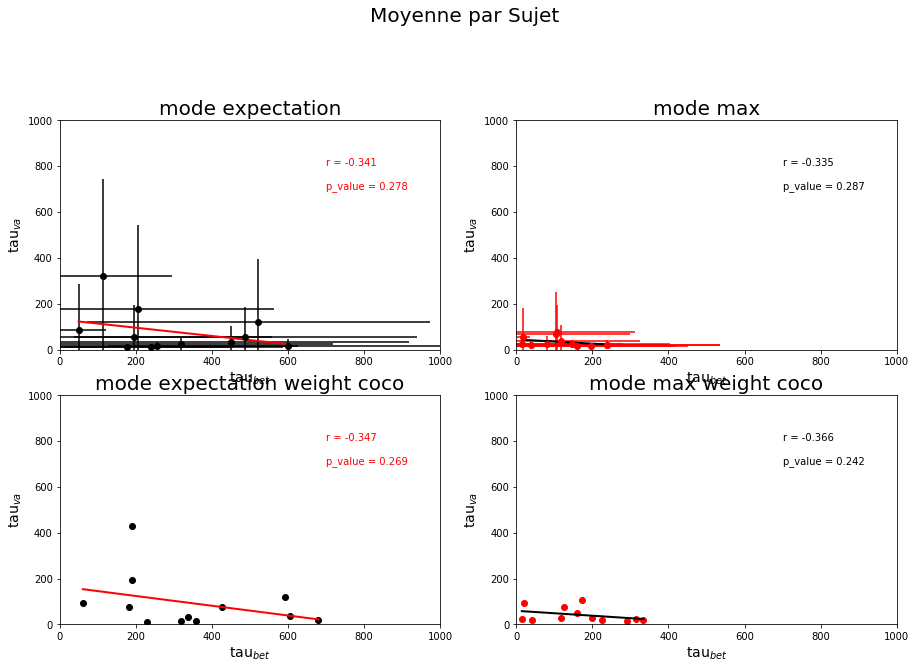

In [15]:
fig, axs = plt.subplots(2, 2, figsize=((fig_width), 2*(fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par Sujet', fontsize=20, y=1.05)

mean_tau_r_e, mean_tau_va_e = [], []
mean_tau_r_m, mean_tau_va_m = [], []

average_tau_r_e, average_tau_va_e = [], []
average_tau_r_m, average_tau_va_m = [], []

for x in range(len(exp)):
    sujet = exp[x]['observer'] # sujet
    N_blocks = exp[x]['N_blocks']
    #axs.plot(range(len(exp)), np.ones(len(exp))*40, color='k', linewidth=2)

    tau_r_e, tau_r_m = [],[]
    coco_r_e, coco_r_m = [],[]

    tau_va_e, tau_va_m = [],[]
    coco_va_e, coco_va_m = [],[]
    
    for block in range(N_blocks) :
        for a in range(len(liste_tau_e[sujet][block])) :

            tau_r_e.append(liste_tau_e[sujet][block][a]['result'][0])
            tau_r_m.append(liste_tau_m[sujet][block][a]['result'][0])
            coco_r_e.append(liste_tau_e[sujet][block][a]['result'][1])
            coco_r_m.append(liste_tau_m[sujet][block][a]['result'][1])
            
            tau_va_e.append(liste_tau_e[sujet][block][a]['va'][0])
            tau_va_m.append(liste_tau_m[sujet][block][a]['va'][0])
            coco_va_e.append(liste_tau_e[sujet][block][a]['va'][1])
            coco_va_m.append(liste_tau_m[sujet][block][a]['va'][1])

    axs[0][0].errorbar(np.mean(tau_r_e), np.mean(tau_va_e), xerr=np.std(tau_r_e), yerr=np.std(tau_va_e),color='k', fmt='o')
    axs[0][1].errorbar(np.mean(tau_r_m), np.mean(tau_va_m), xerr=np.std(tau_r_m),  yerr=np.std(tau_va_m),color='r', fmt='o')
    axs[1][0].scatter(np.average(tau_r_e, weights=coco_r_e), np.average(tau_va_e, weights=coco_va_e), color='k')
    axs[1][1].scatter(np.average(tau_r_m, weights=coco_r_m), np.average(tau_va_m, weights=coco_va_m), color='r')

    mean_tau_r_e.append(np.mean(tau_r_e))
    mean_tau_va_e.append(np.mean(tau_va_e))
    mean_tau_r_m.append(np.mean(tau_r_m))
    mean_tau_va_m.append(np.mean(tau_va_m))
    
    average_tau_r_e.append(np.average(tau_r_e, weights=coco_r_e))
    average_tau_va_e.append(np.average(tau_va_e, weights=coco_va_e))
    average_tau_r_m.append(np.average(tau_r_m, weights=coco_r_m))
    average_tau_va_m.append(np.average(tau_va_m, weights=coco_va_m))

slope, intercept, r_value, p_value, std_err = stats.linregress(mean_tau_r_e, mean_tau_va_e)
x_test = np.linspace(np.min(mean_tau_r_e), np.max(mean_tau_r_e), 100)
fitLine = slope * x_test + intercept
axs[0][0].plot(x_test, fitLine, c='r', linewidth=2)
axs[0][0].text(700,800, 'r = %0.3f'%(r_value), color='r', fontsize=10)
axs[0][0].text(700,700, 'p_value = %0.3f'%(p_value), color='r', fontsize=10)    
    
slope, intercept, r_value, p_value, std_err = stats.linregress(mean_tau_r_m, mean_tau_va_m)
x_test = np.linspace(np.min(mean_tau_r_m), np.max(mean_tau_r_m), 100)
fitLine = slope * x_test + intercept
axs[0][1].plot(x_test, fitLine, c='k', linewidth=2)
axs[0][1].text(700,800, 'r = %0.3f'%(r_value), color='k', fontsize=10)
axs[0][1].text(700,700, 'p_value = %0.3f'%(p_value), color='k', fontsize=10)  
    
slope, intercept, r_value, p_value, std_err = stats.linregress(average_tau_r_e, average_tau_va_e)
x_test = np.linspace(np.min(average_tau_r_e), np.max(average_tau_r_e), 100)
fitLine = slope * x_test + intercept
axs[1][0].plot(x_test, fitLine, c='r', linewidth=2)
axs[1][0].text(700,800, 'r = %0.3f'%(r_value), color='r', fontsize=10)
axs[1][0].text(700,700, 'p_value = %0.3f'%(p_value), color='r', fontsize=10)    
    
slope, intercept, r_value, p_value, std_err = stats.linregress(average_tau_r_m, average_tau_va_m)
x_test = np.linspace(np.min(average_tau_r_m), np.max(average_tau_r_m), 100)
fitLine = slope * x_test + intercept
axs[1][1].plot(x_test, fitLine, c='k', linewidth=2)
axs[1][1].text(700,800, 'r = %0.3f'%(r_value), color='k', fontsize=10)
axs[1][1].text(700,700, 'p_value = %0.3f'%(p_value), color='k', fontsize=10)   
    
    
for a in range(2) :
    axs[a][0].set_xlabel('tau$_{bet}$', fontsize=14)
    axs[a][1].set_xlabel('tau$_{bet}$', fontsize=14)

    axs[a][0].set_ylabel('tau$_{va}$', fontsize=14)
    axs[a][1].set_ylabel('tau$_{va}$', fontsize=14)
    axs[a][0].axis([-0.03, 1000, -0.03, 1000])
    axs[a][1].axis([-0.03, 1000, -0.03, 1000])
    
axs[0][0].set_title('mode expectation', fontsize=20)
axs[0][1].set_title('mode max', fontsize=20)
axs[1][0].set_title('mode expectation weight coco', fontsize=20)
axs[1][1].set_title('mode max weight coco', fontsize=20)

plt.show()

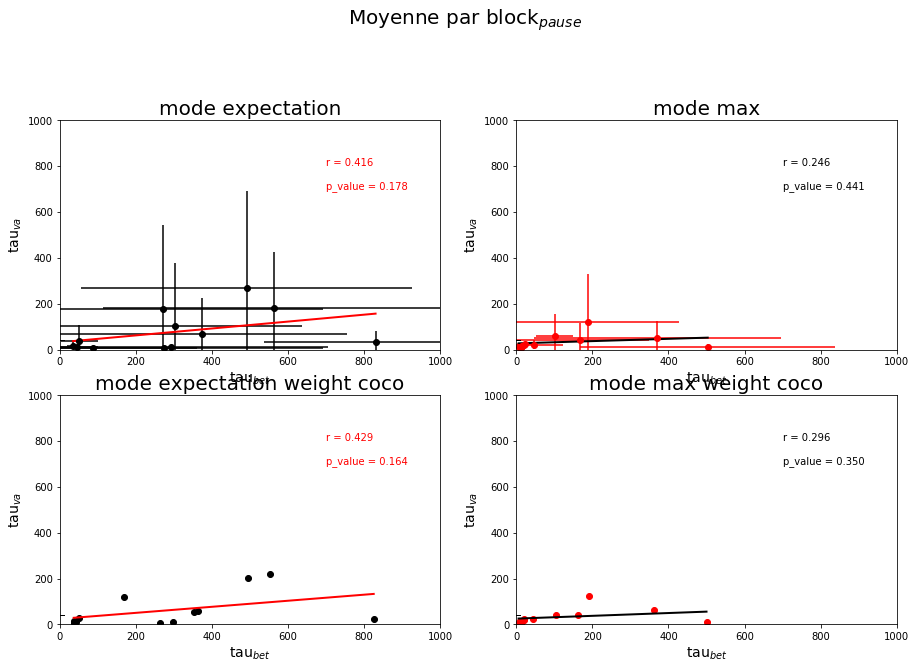

In [16]:
fig, axs = plt.subplots(2, 2, figsize=((fig_width), 2*(fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par block$_{pause}$', fontsize=20, y=1.05)

for a in range(2) :
    axs[a][0].plot(range(len(exp)), np.ones(len(exp))*40, color='k', linewidth=1)
    axs[a][1].plot(range(len(exp)), np.ones(len(exp))*40, color='k', linewidth=1)

tau_r_e, tau_r_m = [],[]
coco_r_e, coco_r_m = [],[]
tau_va_e, tau_va_m = [],[]
coco_va_e, coco_va_m = [],[]
for block in range(N_blocks) :
    for a in range(len(liste_tau_e[sujet][block])) :
        tau_r_e.append([])
        tau_r_m.append([])
        coco_r_e.append([])
        coco_r_m.append([])
        
        tau_va_e.append([])
        tau_va_m.append([])
        coco_va_e.append([])
        coco_va_m.append([])
        
for x in range(len(exp)):
    sujet = exp[x]['observer'] # sujet
    N_blocks = exp[x]['N_blocks']
    
    baba = 0
    for block in range(N_blocks) :
        for a in range(len(liste_tau_e[sujet][block])) :
            tau_r_e[baba].append(liste_tau_e[sujet][block][a]['result'][0])
            tau_r_m[baba].append(liste_tau_m[sujet][block][a]['result'][0])
            coco_r_e[baba].append(liste_tau_e[sujet][block][a]['result'][1])
            coco_r_m[baba].append(liste_tau_m[sujet][block][a]['result'][1])
            
            tau_va_e[baba].append(liste_tau_e[sujet][block][a]['va'][0])
            tau_va_m[baba].append(liste_tau_m[sujet][block][a]['va'][0])
            coco_va_e[baba].append(liste_tau_e[sujet][block][a]['va'][1])
            coco_va_m[baba].append(liste_tau_m[sujet][block][a]['va'][1])
            
            baba=baba+1

            
mean_tau_r_e, mean_tau_va_e = [], []
mean_tau_r_m, mean_tau_va_m = [], []

average_tau_r_e, average_tau_va_e = [], []
average_tau_r_m, average_tau_va_m = [], []

for baba in range(len(tau_r_e)) :
    axs[0][0].errorbar(np.mean(tau_r_e[baba]), np.mean(tau_va_e[baba]), xerr=np.std(tau_r_e[baba]), yerr=np.std(tau_va_e[baba]), color='k', fmt='o')
    axs[0][1].errorbar(np.mean(tau_r_m[baba]), np.mean(tau_va_m[baba]), xerr=np.std(tau_r_m[baba]), yerr=np.std(tau_va_m[baba]), color='r', fmt='o')
    axs[1][0].scatter(np.average(tau_r_e[baba], weights=coco_r_e[baba]), np.average(tau_va_e[baba], weights=coco_va_e[baba]), color='k')
    axs[1][1].scatter(np.average(tau_r_m[baba], weights=coco_r_m[baba]), np.average(tau_va_m[baba], weights=coco_va_m[baba]), color='r')

    mean_tau_r_e.append(np.mean(tau_r_e[baba]))
    mean_tau_va_e.append(np.mean(tau_va_e[baba]))
    mean_tau_r_m.append(np.mean(tau_r_m[baba]))
    mean_tau_va_m.append(np.mean(tau_va_m[baba]))
    
    average_tau_r_e.append(np.average(tau_r_e[baba], weights=coco_r_e[baba]))
    average_tau_va_e.append(np.average(tau_va_e[baba], weights=coco_va_e[baba]))
    average_tau_r_m.append(np.average(tau_r_m[baba], weights=coco_r_m[baba]))
    average_tau_va_m.append(np.average(tau_va_m[baba], weights=coco_va_m[baba]))
    
slope, intercept, r_value, p_value, std_err = stats.linregress(mean_tau_r_e, mean_tau_va_e)
x_test = np.linspace(np.min(mean_tau_r_e), np.max(mean_tau_r_e), 100)
fitLine = slope * x_test + intercept
axs[0][0].plot(x_test, fitLine, c='r', linewidth=2)
axs[0][0].text(700,800, 'r = %0.3f'%(r_value), color='r', fontsize=10)
axs[0][0].text(700,700, 'p_value = %0.3f'%(p_value), color='r', fontsize=10)    
    
slope, intercept, r_value, p_value, std_err = stats.linregress(mean_tau_r_m, mean_tau_va_m)
x_test = np.linspace(np.min(mean_tau_r_m), np.max(mean_tau_r_m), 100)
fitLine = slope * x_test + intercept
axs[0][1].plot(x_test, fitLine, c='k', linewidth=2)
axs[0][1].text(700,800, 'r = %0.3f'%(r_value), color='k', fontsize=10)
axs[0][1].text(700,700, 'p_value = %0.3f'%(p_value), color='k', fontsize=10)  
    
slope, intercept, r_value, p_value, std_err = stats.linregress(average_tau_r_e, average_tau_va_e)
x_test = np.linspace(np.min(average_tau_r_e), np.max(average_tau_r_e), 100)
fitLine = slope * x_test + intercept
axs[1][0].plot(x_test, fitLine, c='r', linewidth=2)
axs[1][0].text(700,800, 'r = %0.3f'%(r_value), color='r', fontsize=10)
axs[1][0].text(700,700, 'p_value = %0.3f'%(p_value), color='r', fontsize=10)    
    
slope, intercept, r_value, p_value, std_err = stats.linregress(average_tau_r_m, average_tau_va_m)
x_test = np.linspace(np.min(average_tau_r_m), np.max(average_tau_r_m), 100)
fitLine = slope * x_test + intercept
axs[1][1].plot(x_test, fitLine, c='k', linewidth=2)
axs[1][1].text(700,800, 'r = %0.3f'%(r_value), color='k', fontsize=10)
axs[1][1].text(700,700, 'p_value = %0.3f'%(p_value), color='k', fontsize=10)  
    
    
    
for a in range(2) :
    axs[a][0].set_xlabel('tau$_{bet}$', fontsize=14)
    axs[a][1].set_xlabel('tau$_{bet}$', fontsize=14)

    axs[a][0].set_ylabel('tau$_{va}$', fontsize=14)
    axs[a][1].set_ylabel('tau$_{va}$', fontsize=14)
    axs[a][0].axis([-0.03, 1000, -0.03, 1000])
    axs[a][1].axis([-0.03, 1000, -0.03, 1000])
    
axs[0][0].set_title('mode expectation', fontsize=20)
axs[0][1].set_title('mode max', fontsize=20)
axs[1][0].set_title('mode expectation weight coco', fontsize=20)
axs[1][1].set_title('mode max weight coco', fontsize=20)

plt.show()

### Reprendre ici